In [1]:
from tqdm.notebook import tqdm
from math import sqrt,erf
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import numpy as np
from varname import nameof
from qutip import *
from matplotlib.cm import get_cmap
import colorcet as cc
import subprocess
import os, shutil
import time
import functools
from scipy import special
from IPython.display import display, clear_output


plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 15,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="white")

D0 = 1
deltaD = 0.01
plt.plot([], [])
plt.show()
clear_output()

9


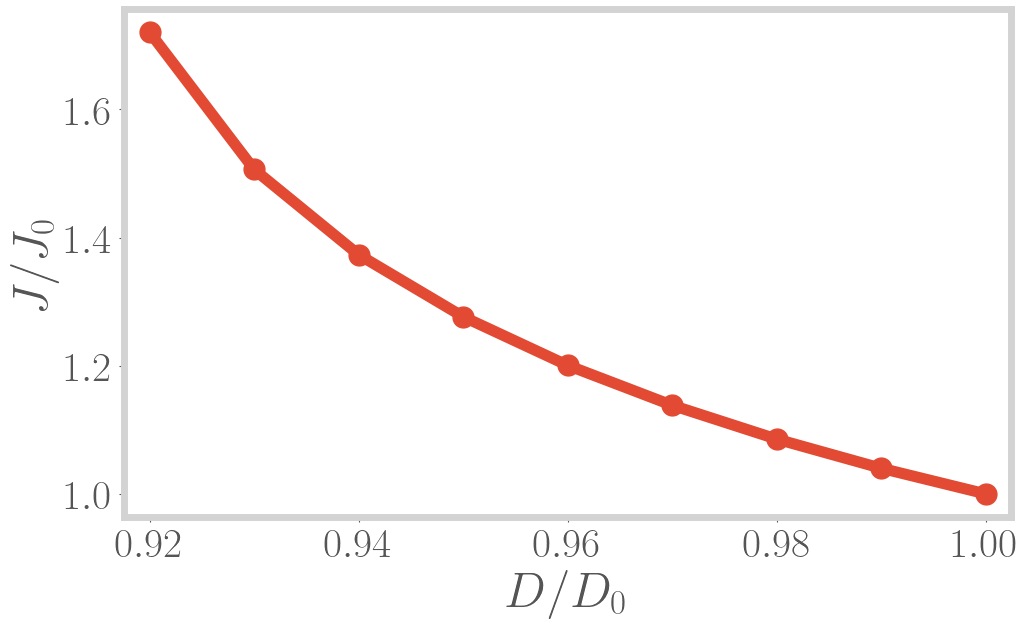

In [2]:
def get_RG_flow(J0_by_D0, Ub_by_J=0, plot=False):
    """ Returns the flow of couplings in the form of two ndarrays J and D.
    Each ndarray is in ascending order of the bandwidth. """
    J0 = D0 * J0_by_D0
    Ub = - Ub_by_J * J0
    omega = -D0/2
    
    ### initialise arrays with UV values
    D = [D0]
    J = [J0]
    
    ### apply URG transformations until bandwith vanishes
    ### or J reduces to zero.
    while D[-1] >= deltaD and J[-1] >= 0:
        
        ### URG equation
        deltaJ = - J[-1] * (J[-1] + 4 * Ub) / (omega - D[-1]/2 + J[-1]/4) * deltaD
        
        ### Check if denominator has changed sign, 
        ### then append renormalised values to array
        if (omega - (D[-1] - deltaD)/2 + (J[-1] + deltaJ)/4) * (omega - D0/2 + J0/4) > 0:
            D.append(D[-1] - deltaD)
            J.append(J[-1] + deltaJ)
        else:
            break
    
    ### plot values
    if plot:
        plt.plot(np.array(D)/D0, np.array(J)/J0, marker="o")
        plt.xlabel(r"$D/D_0$")
        plt.ylabel(r"$J/J_0$")
    return np.flip(D), np.flip(J)

D, J = get_RG_flow(2, Ub_by_J=0, plot=True)
print (len(J))

In [20]:
def get_renorm(coefficients, combinations, savepath, total_num, alpha):
    """ Calculates and returns the renormalised coefficients at a given RG step. """
    q_pos = total_num - 2 ### position of the nearest IOM
    try:
        ### uncomment the next line if you don't want to read from saved data
        raise ValueError('A very bad thing happened.')
        
        ### read from saved data, if available
        new_coefficients = np.load(savepath)['arr_0']
    except:
        ### if saved data is not available, run this block
        
        ### pad earlier coefficients with zeros to make room for new IOM
        new_coefficients = np.copy(coefficients)
        combinations = np.array([list(c) + [0, 0] for c in combinations])
        new_combinations = np.copy(combinations)
        for source_comb in tqdm(combinations, total=len(combinations), leave=False):
            ### loop over spins of IOM, particle/hole sectors as well as cloud members
            for beta, k_pos in product([1, -1], range(1, q_pos-1, 2)):
                beta_pos = int((1 - beta) / 2)
                betabar_pos = int(1 - beta_pos)
    
                ### generate all possible occupancies for qbeta, kbeta, kbetabar and impurity
                ### these are generated only when required and not stored in memory, so as to
                ### reduce physical memory usage.
                if  source_comb[k_pos + beta_pos] == 1 - source_comb[q_pos + beta_pos]:
                    target_comb = np.copy(source_comb)
                    target_comb[k_pos + beta_pos] = 1 - source_comb[k_pos + beta_pos]
                    target_comb[q_pos + beta_pos] = 1 - source_comb[q_pos + beta_pos]
                    if list(target_comb) not in new_combinations.tolist():
                        new_combinations = np.vstack([new_combinations, target_comb])
                        new_coefficients = np.append(new_coefficients, 0)
                    new_coefficients[(new_combinations == target_comb).all(axis=1).nonzero()] += alpha * beta * (source_comb[0] - 0.5) * coefficients[(combinations == source_comb).all(axis=1).nonzero()]
                if  source_comb[k_pos + betabar_pos] == 1 - source_comb[q_pos + beta_pos] and source_comb[0] == 1 - abs((1 - beta)/2 - source_comb[q_pos + beta_pos]):
                    target_comb = np.copy(source_comb)
                    target_comb[k_pos + betabar_pos] = 1 - source_comb[k_pos + betabar_pos]
                    target_comb[q_pos + beta_pos] = 1 - source_comb[q_pos + beta_pos]
                    target_comb[0] = 1 - source_comb[0]
                    if list(target_comb) not in new_combinations.tolist():
                        new_combinations = np.vstack([new_combinations, target_comb])
                        new_coefficients = np.append(new_coefficients, 0)
                    new_coefficients[(new_combinations == target_comb).all(axis=1).nonzero()] += alpha * coefficients[(combinations == source_comb).all(axis=1).nonzero()]
                    
        ### normalise the final coefficients
        new_coefficients /= np.linalg.norm(new_coefficients)
        
        ### Save (with compression!)
        np.savez_compressed(savepath + "-coeff.npz", new_coefficients)
        np.savez_compressed(savepath + "-combs.npz", new_combinations)
    return new_coefficients, new_combinations


def init_wavefunction(J, D, num_in):
    """ Generates the initial wavefunction at the fixed point.
    Returns the coefficients associated with it and the list
    of all possible occupancies for each of the members.
    No IOMS are taken into account at this point."""

    total_num = 1 + 2 * num_in
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_num - i - 2)) for i in range(total_num - 1)]
    c_kup = [c for c in c_all[0::2]]
    c_kdn = [c for c in c_all[1::2]]
    num_kup = [c.dag() * c for c in c_all[0::2]]
    num_kdn = [c.dag() * c for c in c_all[1::2]]
    H = D * tensor(identity(2), sum(num_kup) + sum(num_kdn)) + J * (0.25 * tensor(sigmaz(), (sum(num_kup) - sum(num_kdn)))
                                          + 0.5 * tensor(sigmap(), sum(c_kdn).dag() * sum(c_kup))
                                          + 0.5 * tensor(sigmam(), sum(c_kup).dag() * sum(c_kdn))
                                         )
    E, X = H.eigenstates()
    coefficients = []
    combinations = []
    for comb in product([1,0], repeat=total_num):
        classicalState = tensor([basis(2, 1 - int(comb[0]))] + [basis(2,0)] * (total_num - 1))
        for i,occ in enumerate(comb):
            if i == 0:
                continue
            classicalState = [1, tensor(identity(2), c_all[i - 1].dag())][int(occ)] * classicalState
        weight = np.real(X[0].dag() * classicalState)[0][0]
        if np.round(weight, 5) != 0:
            combinations.append(comb)
            coefficients.append(weight)
    coefficients = np.array(coefficients)
    combinations = np.array(combinations)
    
    return coefficients/np.linalg.norm(coefficients), combinations


def get_tensorRG(J0_by_D0, num_in, num_out):
    D, J = get_RG_flow(J0_by_D0)
    omega = -D0/2
    ### ensure that there are enugh RG steps in J and D
    ### to recouple all IOMS.
    assert len(J) >= num_out
    
    ### obtain the initial coefficients and set of occupancies
    coefficients, combinations = init_wavefunction(J[0], D[0], num_in)
    
    ### save the initial set of coefficients and store the savepath
    ### in the list of savepaths that will be finally returned.
    coefficients_arr = [coefficients]
    savepaths = []
    savepath = "./MERGCoeffs/{:.0f},{:.10f},{:.10f},{:.10f},{:.10f}".format(1 + 2 * num_in, J0_by_D0 * D0, D0, deltaD, omega)
    savepaths.append(savepath)
    os.makedirs("./MERGCoeffs", exist_ok=True)
    np.savez_compressed(savepath + "-coeff.npz", coefficients)
    np.savez_compressed(savepath + "-combs.npz", combinations)
    
    ### initial the next set of coefficients and loop through 
    ### the RG flow to generate the tensor network RG.
    
    new_combinations = np.copy(combinations)
    for Ji, Di in tqdm(zip(J[:num_out], D[:num_out]), total=num_out):
        total_num = 1 + 2 * num_in + 2
        alpha = Ji / (omega - Di/2 + Ji/4)
        savepath = "./MERGCoeffs/{:.0f},{:.10f},{:.10f},{:.10f},{:.10f}".format(total_num, Ji, Di, deltaD, omega)
        
        ### get the next set of coefficients and append the savepath to access them later.
        coefficients, combinations = get_renorm(coefficients, combinations, savepath, total_num, alpha)
        savepaths.append(savepath)
        
        ### increase the number of entangled members.
        num_in += 1
        
    return savepaths


def get_VNE_perstep(args):
    """Returns the VNE at a given RG step."""
    
    savepath, member = args
    
    ### Access the coefficients data for the given RG step.
    coefficients = np.load(savepath + "-coeff.npz")['arr_0']
    combinations = np.load(savepath + "-combs.npz")['arr_0']
    occupancies = np.array(combinations[:,member])
    
    ### Create the reduced density matrix by adding 
    ### the pertinent coefficients.
    rho_reduced = np.zeros([2,2])
    for occ1, comb1, coeff1 in zip(occupancies, combinations, coefficients):
        occ1 = int(occ1)
        rho_reduced[occ1][occ1] += coeff1**2
        comb2 = np.copy(comb1)
        comb2[member] = 1 - occ1
        if comb2.tolist() in combinations.tolist():
            coeff2 = coefficients[combinations.tolist().index(comb2.tolist())]
            rho_reduced[occ1][1 - occ1] += coeff1 * coeff2
    ### Diagonalise reduced DM and return VNE.
    eigvals = np.linalg.eigvalsh(rho_reduced)
    return -np.sum(eigvals * np.log(eigvals))


def get_VNE_RG(J0_by_D0, num_in, num_out, member):
    """Function to obtain the RG flow of the entanglement entropy
    of a particular member"""
    
    ### Get the list of savepaths for the coefficients along the RG flow
    savepaths = get_tensorRG(J0_by_D0, num_in, num_out)
        
    ### Calculate VNE from the coefficients data.
    ### Pool() applies multiprocessing.
    args = [[savepath, member] for savepath in savepaths]
    vne_arr = list(tqdm(Pool(1).imap(get_VNE_perstep, args), total=len(args)))
 
    plt.plot(range(num_out+1), vne_arr, marker='o')
    plt.xlabel(r"RG steps")
    plt.ylabel(r"S$_\text{EE}$")
    plt.show()
    return vne_arr

# c, o = init_wavefunction(1)
# print (c)
# print (o)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

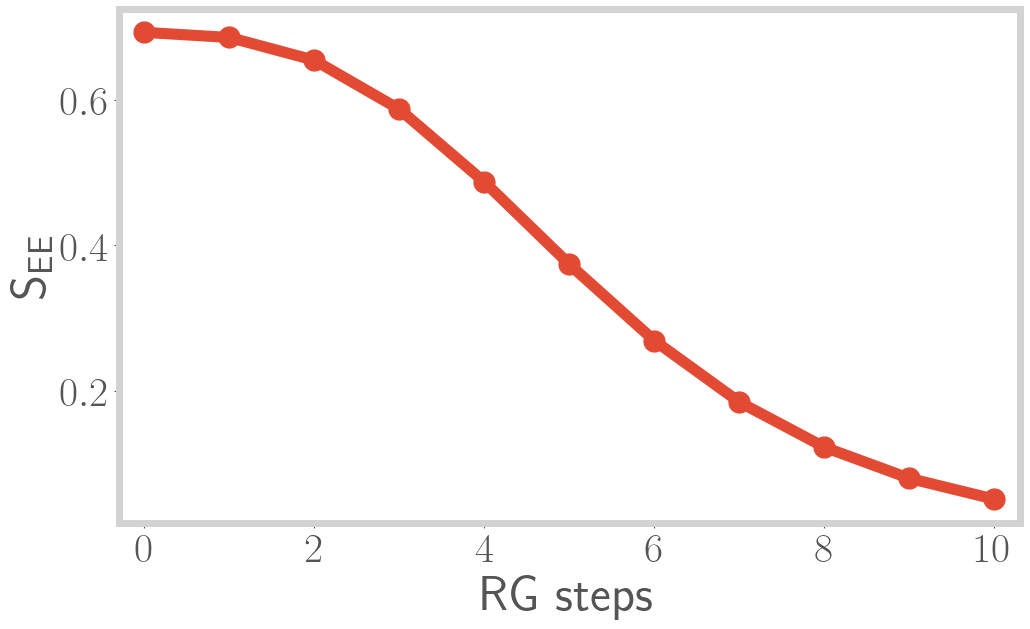

In [23]:
vne_arr = get_VNE_RG(0.1, 1, 10, 1)

In [ ]:
def bruteForceMERG(D0, J0, num_in, num_out):
    omega = -D0/2
    D, J = get_RG_flow(D0, J0)
    assert len(J) >= num_out
    total_dim = 2 + 2 * (num_in + num_out)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sdz = 0.5 * (c_all[0].dag() * c_all[0] - c_all[1].dag() * c_all[1])
    vacuum = tensor([basis(2,0)]*total_dim)
    init_state = 0
    for k_pos in range(2, 2 * num_in + 1, 2):
        init_state += c_all[0].dag() * c_all[k_pos + 1].dag() * vacuum
        init_state += - c_all[1].dag() * c_all[k_pos].dag() * vacuum
    gstates = [init_state.unit()]
    ref_state1 = c_all[7].dag() * c_all[3] * gstates[0]


    for Ji, Eq in tqdm(zip(J[:num_out], D[:num_out]), total=num_out):
        q_pos = 2 + 2 * num_in
        alpha = Ji / (omega - Eq/2 + Ji/4)
        eta = 0
        eta_dag = 0
        for k_pos in range(2, q_pos-1, 2):
            for beta in [1, -1]:
                beta_pos = 0 if beta == 1 else 1
                eta += alpha * Sdz * beta * c_all[k_pos + beta_pos].dag() * c_all[q_pos + beta_pos]
                eta += alpha * c_all[beta_pos].dag() * c_all[1 - beta_pos] * c_all[k_pos + 1 - beta_pos].dag() * c_all[q_pos + beta_pos]
                eta_dag += alpha * Sdz * beta * c_all[q_pos + beta_pos].dag() * c_all[k_pos + beta_pos]
                eta_dag += alpha * c_all[1 - beta_pos].dag() * c_all[beta_pos] * c_all[q_pos + beta_pos].dag() * c_all[k_pos + 1 - beta_pos]
        gstates.append(((1 + eta + eta_dag) * gstates[-1]).unit())
        num_in += 1
        num_out -= 1

    for i,state in enumerate(gstates):
        rho_k = (state * state.dag()).ptrace([2])
        print ((ref_state1.dag() * state)[0][0][0], entropy_vn(rho_k))
        plt.scatter(i, entropy_vn(rho_k))
        
bruteForceMERG(2, 0.2, 1, 4)

In [ ]:
total_num = 3
np.array(list(product([1,0], repeat=total_num)))[:,1]